Here we show how to use our package for benchmarking local descriptors, available in [kornia](https://github.com/kornia/kornia). 

In [ ]:
!pip install git+https://github.com/kornia/kornia
!pip install fastprogress

  Cloning https://github.com/kornia/kornia to /tmp/pip-req-build-iakde2vw
  Running command git clone -q https://github.com/kornia/kornia /tmp/pip-req-build-iakde2vw
  Created wheel for kornia: filename=kornia-0.4.1+95af063-py2.py3-none-any.whl size=206221 sha256=8688579ac6d4ca9edb39446205fcdaaf87071d4ce75611c10cbd544c8807aa5a
  Stored in directory: /tmp/pip-ephem-wheel-cache-zapz74pp/wheels/11/65/a7/13eae13076f57abdf5fd33aefe7e0586ab7c3470cc938ef7ba
Successfully built kornia
  Attempting uninstall: kornia
    Found existing installation: kornia 0.4.1+0c9e625
    Uninstalling kornia-0.4.1+0c9e625:
      Successfully uninstalled kornia-0.4.1+0c9e625


In [ ]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torchvision as tv
import os
from fastprogress.fastprogress import progress_bar
from brown_phototour_revisited.dataset import PhotoTourRevisited
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import paired_distances
from sklearn.metrics import average_precision_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We will store dataset locally and resize patches to 32x32

In [ ]:
dataset_root = './tmp/'
test_dataset_names = ['yosemite', 'notredame', 'liberty']
BS = 256
patch_size = 32
device = torch.device('cuda:0')
transform = tv.transforms.Compose([
            tv.transforms.ToPILImage(),
            tv.transforms.Resize(patch_size),
            tv.transforms.ToTensor()])
kwargs = {'num_workers': 4, 'pin_memory': True} 

Now it is time to extract descriptors and save them together with labels.
We will use [kornia](https://github.com/kornia/kornia) implementation of the SIFT descriptor

In [ ]:
import kornia.feature as KF
SIFT = KF.SIFTDescriptor(32, rootsift=False).eval().to(device)

In [ ]:
save_descs_to = 'descriptors'
if not os.path.isdir(save_descs_to):
    os.makedirs(save_descs_to)

for ds_name in test_dataset_names:
    ds_loader = torch.utils.data.DataLoader(
             PhotoTourRevisited(root=dataset_root,
                     name=ds_name,
                     download=True,
                     transform=transform),
                        batch_size=BS,
                        shuffle=False, drop_last = False, **kwargs)
    num_patches = len(ds_loader.dataset)
    DESC_NAME = f'KorniaSIFT_{patch_size}_{ds_name}'
    desc_fname = f'{save_descs_to}/{DESC_NAME}.npy'
    if os.path.isfile(desc_fname):
        print (f"{desc_fname} already exists, skipping")
        continue
    labels, img_labels =  np.zeros((num_patches)), np.zeros((num_patches))
    descriptors = None
    with torch.no_grad():
        count = 0
        for patch, label, img_label in progress_bar(ds_loader):
            desc = SIFT(patch.to(device))
            bs = len(patch)
            if descriptors is None:
                dim = desc.size(1)
                descriptors = np.zeros((num_patches,dim))
            descriptors[count:count+bs] = desc.cpu().detach().numpy()
            labels[count:count+bs] = label
            img_labels[count:count+bs] = img_label
            count+=bs
    labels_fname = f'{save_descs_to}/{DESC_NAME}_labels.npy'
    img_labels_fname = f'{save_descs_to}/{DESC_NAME}_imglabels.npy'
    np.save(desc_fname, descriptors)
    np.save(labels_fname, labels)
    np.save(img_labels_fname, img_labels)
    print (f'{ds_name} extracted and saved to {desc_fname}')

# Found cached data ./tmp/yosemite.pt


yosemite extracted and saved to descriptors/KorniaSIFT_32_yosemite.npy


KeyboardInterrupt: 

Now time for evaluation

In [ ]:
from brown_phototour_revisited.benchmarking import evaluate_mAP_snn_based

In [ ]:
mAP = evaluate_mAP_snn_based(descriptors, labels, img_labels)

1162
4954
6906
2096
194
1277
7066
4722
696
1667
440
4783
7756
1426
863
5465
3620
7180
6577
2218
2397
5815
2399
9962
1156
5753
1064
1543
4298
6004
760
417
1084
971
6322
1115
9395
9813


In [ ]:
tt = np.eye(5)

ValueError: invalid number of arguments

In [ ]:


def evaluate_mAP_snn_based(descriptors, labels, img_labels):
    APs = []
    unique_img_labels = sorted(np.unique(img_labels))
    for img_idx in unique_img_labels:
        current_batch = img_labels == img_idx
        cur_descs = descriptors[current_batch]
        cur_labels = labels[current_batch]
        NN = cur_labels.shape[0]
        pos_matrix = (cur_labels[None].expand(NN,NN) == cur_labels[...,None].expand(NN,NN)) != (torch.eye(NN).to(cur_labels.device)>0)
        #print ('pos_matrix_done')
        neg = torch.zeros(NN).long()

        if NN > 2000: # To avoid OOM, we will find hard minimum in batches
            bs1 = 128
            nb = (NN // bs1)  
            for i in range(nb):
                st = i*bs1
                fin = min(NN, (i+1)*bs1)
                if fin == st:
                    break
                dm = (torch.cdist(cur_descs[st:fin], cur_descs) +
                      1000.0 * (pos_matrix[st:fin].to(cur_descs.dtype)) + 
                    1000.0*torch.eye(NN)[st:fin].to(cur_labels.device).to(cur_descs.dtype))
                min_idx = torch.min(dm, dim=1)[1]
                neg[st:fin] = min_idx       
    #anc, pos, neg = Miner(cur_descs, cur_labels)
    pos_idxs = torch.arange(NN)[None].expand(NN,NN)[pos_matrix]
    anc_idxs = torch.nonzero(pos_matrix)[:,0]
    pos_matrix = None
    neg_idxs = neg[anc_idxs]
    pos_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[pos_idxs])
    neg_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[neg_idxs])
    correct = pos_dists <= neg_dists
    snn = torch.min(pos_dists,neg_dists) / torch.max(pos_dists,neg_dists)
    snn[torch.isnan(snn)] = 1.0
    #precision, recall, thresholds = precision_recall_curve(correct, 1-snn)
    ap = average_precision_score(correct, 1-snn)
    #prec_per_img.append(precision)
    #rec_per_img.append(recall)
    #ths_per_img.append(thresholds)
    aps.append(ap)
current_batch = all_img_labels == img_labels_unique[-1].item()
descriptors = [descriptors[current_batch]]
all_img_labels = [all_img_labels[current_batch]]
all_labels = [all_labels[current_batch]]
gc.collect()

    return
def eval_descriptor_on_dataset( desc,
    aps = []
    print ('Extracting descriptors and calculating AP')
    for patches, labels, img_labels in progress_bar(dl_train):
        with torch.no_grad():
            descs = desc(patches)
            descriptors.append(descs)
            all_labels.append(labels)
            all_img_labels.append(img_labels)
            all_img_labels_cat = torch.cat(all_img_labels)
            img_labels_unique = torch.sort(torch.unique(all_img_labels_cat).long())[0]
            new_max_img = img_labels_unique.max().item()
            new_min_img = img_labels_unique.min().item()
            if new_min_img != new_max_img:
                all_img_labels = torch.cat(all_img_labels)
                descriptors = torch.cat(descriptors)
                all_labels = torch.cat(all_labels)
    all_img_labels = torch.cat(all_img_labels)
    descriptors = torch.cat(descriptors)
    all_labels = torch.cat(all_labels)
    for ii in img_labels_unique:
        current_batch = all_img_labels == ii
        cur_descs = descriptors[current_batch].cpu()
        cur_labels = all_labels[current_batch].cpu()
        NN = cur_labels.size(0)
        
        pos_matrix = (cur_labels[None].expand(NN,NN) == cur_labels[...,None].expand(NN,NN)) != (torch.eye(NN).to(cur_labels.device)>0)
        #print ('pos_matrix_done')
        neg = torch.zeros(NN).long()
        if NN > 5000:
            bs1 = 128
            nb = (NN // bs1)  
            for bi in range(nb):
                st = bi*bs1
                fin = min(NN, (bi+1)*bs1)
                if fin == st:
                    break
                dm = (torch.cdist(cur_descs[st:fin], cur_descs) +
                      1000.0 * (pos_matrix[st:fin].to(cur_descs.dtype)) + 
                      1000.0*torch.eye(NN)[st:fin].to(cur_labels.device).to(cur_descs.dtype))
                min_idx = torch.min(dm, dim=1)[1]
                neg[st:fin] = min_idx       
        pos_idxs = torch.arange(NN)[None].expand(NN,NN)[pos_matrix]
        anc_idxs = torch.nonzero(pos_matrix)[:,0]
        pos_matrix = None
        neg_idxs = neg[anc_idxs]
        pos_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[pos_idxs])
        neg_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[neg_idxs])
        correct = pos_dists <= neg_dists
        snn = torch.min(pos_dists,neg_dists) / torch.max(pos_dists,neg_dists)
        snn[torch.isnan(snn)] = 1.0
        #precision, recall, thresholds = precision_recall_curve(correct, 1-snn)
        #prec_per_img.append(precision)
        #rec_per_img.append(recall)
        #ths_per_img.append(thresholds)
        ap = average_precision_score(correct, 1-snn)
        aps.append(ap)
    descriptors = None
    all_labels = None
    all_img_labels = None
    dataset=None
    dl_train = None
    gc.collect()
    return aps
    #return {"precision": prec_per_img, "recall": rec_per_img, "thresholds": ths_per_img}


633587

In [ ]:
import kornia as K

In [ ]:

import random
from fastai2.basics import *
from fastcore import *
from fastai2.vision.all import *
from fastai2.callback.all import *
from fastprogress import fastprogress
from fastai2.callback.mixup import *
from fastscript import *
import torchvision as tv
import kornia as K
import gc
from pytorch_metric_learning import losses, miners

def imshow_torch(tensor, *kwargs):
    plt.figure()
    plt.imshow(K.tensor_to_image(tensor), *kwargs)
    return

In [ ]:
train_ds_name = 'liberty'
val_ds_names = ['notredame', 'yosemite']

ds_root = '/home/mishkdmy/datasets/Brown/'

'0.4.1+0c9e625'

In [ ]:
torch.version.__version__

desc = K.feature.SOSNet(True)


import torch
from torch import nn
import torch.nn.functional as F

class TNet(nn.Module):
    """TFeat model definition
    """
    def __init__(self):
        super(TNet, self).__init__()
        self.features = nn.Sequential(
            nn.InstanceNorm2d(1, affine=False),
            nn.Conv2d(1, 32, kernel_size=7),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=6),
            nn.Tanh()
        )
        self.descr = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.descr(x)
        return x
    


In [ ]:
!wget https://github.com/vbalnt/tfeat/raw/master/pretrained-models/tfeat-liberty.params

--2020-09-08 17:43:48--  https://github.com/vbalnt/tfeat/raw/master/pretrained-models/tfeat-liberty.params
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vbalnt/tfeat/master/pretrained-models/tfeat-liberty.params [following]
--2020-09-08 17:43:48--  https://raw.githubusercontent.com/vbalnt/tfeat/master/pretrained-models/tfeat-liberty.params
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.16.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.16.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2400533 (2.3M) [application/octet-stream]
Saving to: ‘tfeat-liberty.params’

100%[======================================>] 2,400,533   --.-K/s   in 0.1s    

2020-09-08 17:43:57 (20.5 MB/s) - ‘tfeat-liberty.params’ saved [2400533/2400533]



In [ ]:
tfeat = TNet().eval()
tfeat.load_state_dict(torch.load('tfeat-liberty.params'))

<All keys matched successfully>

In [ ]:
def eval_descriptor_on_dataset( desc,
    ds_name='notredame',
    resol=100,
    device=torch.device('cuda:0'),
    ds_root = '/home/mishkdmy/datasets/Brown'):
    
    desc.eval()
    desc = desc.to(device)
    dataset = PhotoTourRevisited(ds_root,
                      ds_name,
                       train=False, 
                       download=True)
    orig_size = 64
    out_size = 32
    test_aug = nn.Sequential( 
        K.Resize((out_size,out_size), interpolation='bicubic'))
    BS = 1024
    TEST_BS = 128
    N_WORKERS = 4
    
    dl_train = TfmdDL(dataset,
                 device=device,
                 after_item=[ToTensor], 
                 after_batch=[TupleAug(test_aug)], #two patches -> single tensor
                 bs=BS, num_workers=N_WORKERS,
                 shuffle = False)
    num_patches = len(dl_train.dataset)
    descriptors = []#torch.zeros(num_patches, 128)
    all_labels = []#torch.zeros(num_patches)
    all_img_labels = []#torch.zeros(num_patches)
    Miner = miners.BatchHardMiner()
    count = 0 
    max_img = -1
    min_img = 1000
    prec_per_img = []
    rec_per_img = []
    ths_per_img = []
    aps = []
    print ('Extracting descriptors and calculating AP')
    for patches, labels, img_labels in progress_bar(dl_train):
        with torch.no_grad():
            descs = desc(patches)
            descriptors.append(descs)
            all_labels.append(labels)
            all_img_labels.append(img_labels)
            all_img_labels_cat = torch.cat(all_img_labels)
            img_labels_unique = torch.sort(torch.unique(all_img_labels_cat).long())[0]
            new_max_img = img_labels_unique.max().item()
            new_min_img = img_labels_unique.min().item()
            if new_min_img != new_max_img:
                all_img_labels = torch.cat(all_img_labels)
                descriptors = torch.cat(descriptors)
                all_labels = torch.cat(all_labels)
                for ii in img_labels_unique[:-1]:
                    current_batch = all_img_labels == ii
                    cur_descs = descriptors[current_batch].cpu()
                    #print (cur_descs.shape)
                    cur_labels = all_labels[current_batch].cpu().long()
                    NN = cur_labels.size(0)
                    pos_matrix = (cur_labels[None].expand(NN,NN) == cur_labels[...,None].expand(NN,NN)) != (torch.eye(NN).to(cur_labels.device)>0)
                    #print ('pos_matrix_done')
                    neg = torch.zeros(NN).long()
                    
                    if NN > 2000: # To avoid OOM, we will find hard minimum in batches
                        bs1 = 128
                        nb = (NN // bs1)  
                        for i in range(nb):
                            st = i*bs1
                            fin = min(NN, (i+1)*bs1)
                            if fin == st:
                                break
                            dm = (torch.cdist(cur_descs[st:fin], cur_descs) +
                                  1000.0 * (pos_matrix[st:fin].to(cur_descs.dtype)) + 
                                1000.0*torch.eye(NN)[st:fin].to(cur_labels.device).to(cur_descs.dtype))
                            min_idx = torch.min(dm, dim=1)[1]
                            neg[st:fin] = min_idx       
                    #anc, pos, neg = Miner(cur_descs, cur_labels)
                    pos_idxs = torch.arange(NN)[None].expand(NN,NN)[pos_matrix]
                    anc_idxs = torch.nonzero(pos_matrix)[:,0]
                    pos_matrix = None
                    neg_idxs = neg[anc_idxs]
                    pos_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[pos_idxs])
                    neg_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[neg_idxs])
                    correct = pos_dists <= neg_dists
                    snn = torch.min(pos_dists,neg_dists) / torch.max(pos_dists,neg_dists)
                    snn[torch.isnan(snn)] = 1.0
                    #precision, recall, thresholds = precision_recall_curve(correct, 1-snn)
                    ap = average_precision_score(correct, 1-snn)
                    #prec_per_img.append(precision)
                    #rec_per_img.append(recall)
                    #ths_per_img.append(thresholds)
                    aps.append(ap)
                current_batch = all_img_labels == img_labels_unique[-1].item()
                descriptors = [descriptors[current_batch]]
                all_img_labels = [all_img_labels[current_batch]]
                all_labels = [all_labels[current_batch]]
                gc.collect()
    all_img_labels = torch.cat(all_img_labels)
    descriptors = torch.cat(descriptors)
    all_labels = torch.cat(all_labels)
    for ii in img_labels_unique:
        current_batch = all_img_labels == ii
        cur_descs = descriptors[current_batch].cpu()
        cur_labels = all_labels[current_batch].cpu()
        NN = cur_labels.size(0)
        
        pos_matrix = (cur_labels[None].expand(NN,NN) == cur_labels[...,None].expand(NN,NN)) != (torch.eye(NN).to(cur_labels.device)>0)
        #print ('pos_matrix_done')
        neg = torch.zeros(NN).long()
        if NN > 5000:
            bs1 = 128
            nb = (NN // bs1)  
            for bi in range(nb):
                st = bi*bs1
                fin = min(NN, (bi+1)*bs1)
                if fin == st:
                    break
                dm = (torch.cdist(cur_descs[st:fin], cur_descs) +
                      1000.0 * (pos_matrix[st:fin].to(cur_descs.dtype)) + 
                      1000.0*torch.eye(NN)[st:fin].to(cur_labels.device).to(cur_descs.dtype))
                min_idx = torch.min(dm, dim=1)[1]
                neg[st:fin] = min_idx       
        pos_idxs = torch.arange(NN)[None].expand(NN,NN)[pos_matrix]
        anc_idxs = torch.nonzero(pos_matrix)[:,0]
        pos_matrix = None
        neg_idxs = neg[anc_idxs]
        pos_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[pos_idxs])
        neg_dists = F.pairwise_distance(cur_descs[anc_idxs], cur_descs[neg_idxs])
        correct = pos_dists <= neg_dists
        snn = torch.min(pos_dists,neg_dists) / torch.max(pos_dists,neg_dists)
        snn[torch.isnan(snn)] = 1.0
        #precision, recall, thresholds = precision_recall_curve(correct, 1-snn)
        #prec_per_img.append(precision)
        #rec_per_img.append(recall)
        #ths_per_img.append(thresholds)
        ap = average_precision_score(correct, 1-snn)
        aps.append(ap)
    descriptors = None
    all_labels = None
    all_img_labels = None
    dataset=None
    dl_train = None
    gc.collect()
    return aps
    #return {"precision": prec_per_img, "recall": rec_per_img, "thresholds": ths_per_img}

    

    

from collections import defaultdict
results = defaultdict(dict) 

In [ ]:
from collections import defaultdict
results = defaultdict(dict)
for ds_name in val_ds_names:
    print (ds_name)
    for desc, desc_name in zip([
         tfeat], ['TFeat']):
        print (desc_name)
        results[ds_name][desc_name] = eval_descriptor_on_dataset(desc,
                                                                 ds_name, resol=50)
        print (f'{desc_name} mAP = {np.array(results[ds_name][desc_name]).mean():.3f}')


notredame
TFeat
# Found cached data /home/mishkdmy/datasets/Brown/notredame.pt
Extracting descriptors and calculating AP


/home/mishkdmy/.conda/envs/fastai1/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


TFeat mAP = 0.626
yosemite
TFeat
# Found cached data /home/mishkdmy/datasets/Brown/yosemite.pt
Extracting descriptors and calculating AP


TFeat mAP = 0.731


In [ ]:
!wget https://github.com/lg-zhang/dynamic-soft-margin-pytorch/raw/master/pretrained/liberty_float/model.state_dict

--2020-09-08 17:51:35--  https://github.com/lg-zhang/dynamic-soft-margin-pytorch/raw/master/pretrained/liberty_float/model.state_dict
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lg-zhang/dynamic-soft-margin-pytorch/master/pretrained/liberty_float/model.state_dict [following]
--2020-09-08 17:51:36--  https://raw.githubusercontent.com/lg-zhang/dynamic-soft-margin-pytorch/master/pretrained/liberty_float/model.state_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.16.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.16.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5347698 (5.1M) [application/octet-stream]
Saving to: ‘model.state_dict’

100%[======================================>] 5,347,698   28.7MB/s   in 0.2s   

2020-09-08 17:51

In [ ]:
softmargin = K.feature.HardNet(False)
softmargin.load_state_dict(torch.load('model.state_dict'))
softmargin.eval()

HardNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (14): R

In [ ]:
#from collections import defaultdict
#results = defaultdict(dict)
for ds_name in val_ds_names:
    print (ds_name)
    for desc, desc_name in zip([
         softmargin], ['Dynamic SoftMargin']):
        print (desc_name)
        results[ds_name][desc_name] = eval_descriptor_on_dataset(desc,
                                                                 ds_name, resol=50)
        print (f'{desc_name} mAP = {np.array(results[ds_name][desc_name]).mean():.3f}')


notredame
Dynamic SoftMargin
# Found cached data /home/mishkdmy/datasets/Brown/notredame.pt
Extracting descriptors and calculating AP


Dynamic SoftMargin mAP = 0.688
yosemite
Dynamic SoftMargin
# Found cached data /home/mishkdmy/datasets/Brown/yosemite.pt
Extracting descriptors and calculating AP


Dynamic SoftMargin mAP = 0.775


In [ ]:
#from collections import defaultdict
#results = defaultdict(dict)
for ds_name in val_ds_names:
    print (ds_name)
    for desc, desc_name in zip([
         K.feature.SIFTDescriptor(32, rootsift=True).to(torch.device('cuda:0')),
         K.feature.SIFTDescriptor(32, rootsift=False).to(torch.device('cuda:0')),
        K.feature.HardNet(True),
        K.feature.SOSNet(True)], ['RootSIFT', 'SIFT', 'HardNet', 'SOSNet']):
        print (desc_name)
        results[ds_name][desc_name] = eval_descriptor_on_dataset(desc,
                                                                 ds_name, resol=50)
        print (f'{desc_name} mAP = {np.array(results[ds_name][desc_name]).mean():.3f}')


notredame
RootSIFT
# Found cached data /home/mishkdmy/datasets/Brown/notredame.pt
Extracting descriptors and calculating AP


/home/mishkdmy/.conda/envs/fastai1/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


RootSIFT mAP = 0.579
SIFT
# Found cached data /home/mishkdmy/datasets/Brown/notredame.pt
Extracting descriptors and calculating AP


SIFT mAP = 0.569
HardNet
# Found cached data /home/mishkdmy/datasets/Brown/notredame.pt
Extracting descriptors and calculating AP


HardNet mAP = 0.686
SOSNet
# Found cached data /home/mishkdmy/datasets/Brown/notredame.pt
Extracting descriptors and calculating AP


SOSNet mAP = 0.688
yosemite
RootSIFT
# Found cached data /home/mishkdmy/datasets/Brown/yosemite.pt
Extracting descriptors and calculating AP


RootSIFT mAP = 0.682
SIFT
# Found cached data /home/mishkdmy/datasets/Brown/yosemite.pt
Extracting descriptors and calculating AP


SIFT mAP = 0.685
HardNet
# Found cached data /home/mishkdmy/datasets/Brown/yosemite.pt
Extracting descriptors and calculating AP


HardNet mAP = 0.777
SOSNet
# Found cached data /home/mishkdmy/datasets/Brown/yosemite.pt
Extracting descriptors and calculating AP


SOSNet mAP = 0.776


In [ ]:
class HardNetPS(nn.Module):
    def __init__(self):
        super(HardNetPS, self).__init__()
        self.features = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1, bias = True),
        nn.BatchNorm2d(32, affine=True),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=3, padding=1, bias = True),
        nn.BatchNorm2d(32, affine=True),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias = True),
        nn.BatchNorm2d(64, affine=True),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, padding=1, bias = True),
        nn.BatchNorm2d(64, affine=True),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=2,padding=1, bias = True),
        nn.BatchNorm2d(128, affine=True),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, padding=1, bias = True),
        nn.BatchNorm2d(128, affine=True),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=8, bias = True)
    )
    def input_norm(self,x):
        flat = x.view(x.size(0), -1)
        mp = torch.mean(flat, dim=1)
        sp = torch.std(flat, dim=1) + 1e-7
        return (x - mp.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand_as(x)) / sp.unsqueeze(-1).unsqueeze(-1).unsqueeze(1).expand_as(x)

    def forward(self, input):
        x_features = self.features(self.input_norm(input))
        x = x_features.view(x_features.size(0), -1)
        return F.normalize(x, dim=1, p=2)
hnps = HardNetPS()
!wget https://github.com/DagnyT/hardnet/raw/master/pretrained/3rd_party/HardNetPS/HardNetPS.pth

--2020-09-08 18:06:05--  https://github.com/DagnyT/hardnet/raw/master/pretrained/3rd_party/HardNetPS/HardNetPS.pth
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/DagnyT/hardnet/master/pretrained/3rd_party/HardNetPS/HardNetPS.pth [following]
--2020-09-08 18:06:05--  https://raw.githubusercontent.com/DagnyT/hardnet/master/pretrained/3rd_party/HardNetPS/HardNetPS.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.16.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.16.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5351453 (5.1M) [application/octet-stream]
Saving to: ‘HardNetPS.pth.1’

100%[======================================>] 5,351,453   30.4MB/s   in 0.2s   

2020-09-08 18:06:13 (30.4 MB/s) - ‘HardNetPS.pth.1’ saved [5351453/5351453

In [ ]:
hnps.load_state_dict(torch.load('HardNetPS.pth'))
hnps.eval()

HardNetPS(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1,

In [ ]:
#from collections import defaultdict
#results = defaultdict(dict)
for ds_name in val_ds_names:
    print (ds_name)
    for desc, desc_name in zip([
         hnps], ['HardNetPS']):
        print (desc_name)
        results[ds_name][desc_name] = eval_descriptor_on_dataset(desc,
                                                                 ds_name, resol=50)
        print (f'{desc_name} mAP = {np.array(results[ds_name][desc_name]).mean():.3f}')
        break


notredame
HardNetPS
# Found cached data /home/mishkdmy/datasets/Brown/notredame.pt
Extracting descriptors and calculating AP


HardNetPS mAP = 0.592
yosemite
HardNetPS
# Found cached data /home/mishkdmy/datasets/Brown/yosemite.pt
Extracting descriptors and calculating AP


KeyboardInterrupt: 

In [ ]:
!wget http://cmp.felk.cvut.cz/~qqpultar/Weights/Weights-HardNet8.zip

--2020-09-08 18:13:36--  http://cmp.felk.cvut.cz/~qqpultar/Weights/Weights-HardNet8.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170412676 (163M) [application/zip]
Saving to: ‘Weights-HardNet8.zip’

100%[======================================>] 170,412,676  525MB/s   in 0.3s   

2020-09-08 18:13:36 (525 MB/s) - ‘Weights-HardNet8.zip’ saved [170412676/170412676]



In [ ]:
!unzip Weights-HardNet8.zip

Archive:  Weights-HardNet8.zip
  inflating: HardNet8-PT.jitpt       
  inflating: HardNet8-PT.pt          
  inflating: HardNet8-PTv2.jitpt     
  inflating: HardNet8-PTv2.pt        
  inflating: HardNet8-Univ.jitpt     
  inflating: HardNet8-Univ.pt        


In [ ]:
hnuniv = torch.jit.load('HardNet8-Univ.jitpt')

In [ ]:
#from collections import defaultdict
#results = defaultdict(dict)
for ds_name in val_ds_names:
    print (ds_name)
    for desc, desc_name in zip([
         hnuniv], ['HardNet8-Univ']):
        print (desc_name)
        results[ds_name][desc_name] = eval_descriptor_on_dataset(desc,
                                                                 ds_name, resol=50)
        print (f'{desc_name} mAP = {np.array(results[ds_name][desc_name]).mean():.3f}')
    break


notredame
HardNet8-Univ
# Found cached data /home/mishkdmy/datasets/Brown/notredame.pt
Extracting descriptors and calculating AP


HardNet8-Univ mAP = 0.699


In [ ]:
reslist = [ 0.569,0.579,  0.592, 0.626, 0.686, 0.688, 0.688, 0.699]

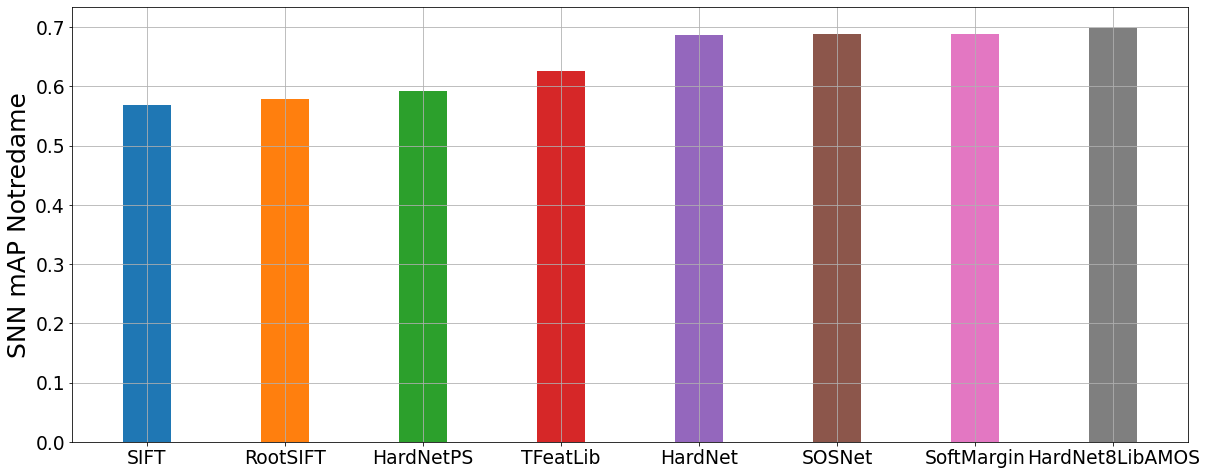

In [ ]:
size=25
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

#plt.bar(np.arange(len(reslist)), reslist)
#plt.figure(figsize=(12,8))
for i in range(len(reslist)):
    plt.bar(2.3*i, reslist[i])
#plt.legend( ['SIFT', 'RootSIFT', 'TFeatLib', "HardNet", "SOSNet", "DynSoftMargin"])
plt.ylabel('SNN mAP Notredame')
plt.ylabel('SNN mAP Notredame')

plt.xticks(2.3*np.arange(len(reslist)), ['SIFT', 'RootSIFT', 'HardNetPS', 'TFeatLib', "HardNet", "SOSNet", "SoftMargin", 'HardNet8LibAMOS'])
#plt.legend()
plt.grid('on')

In [ ]:
for ds_name in val_ds_names:
    print (ds_name)
    for desc, desc_name in zip([
         K.feature.SIFTDescriptor(32, rootsift=True).to(torch.device('cuda:0')),
         K.feature.SIFTDescriptor(32, rootsift=False).to(torch.device('cuda:0')),
        K.feature.HardNet(True),
        K.feature.SOSNet(True)], ['RootSIFT', 'SIFT', 'HardNet', 'SOSNet']):
        print (desc_name)
        results[ds_name][desc_name] = eval_descriptor_on_dataset(desc,
                                                                 ds_name, resol=50)
        print (f'{desc_name} mAP = {np.array(results[ds_name][desc_name]).mean():.3f}')
